## Gas-usage


In [ ]:
# export 
class ToElapsed():
    changed = False    
    def __call__(self, s):
        if pd.api.types.is_datetime64_any_dtype(s.dtype):            
            self.changed = True
            return s.astype(np.int64) // 10 ** 9
        return s
    
    def decode(self, s):
        if self.changed:    
            return pd.Series(pd.to_datetime(s *(10 ** 9)))
        return s
    

In [ ]:
# hide
s = pd.Series([pd.Timestamp('1970')+pd.Timedelta(hours=1)*x for x in range(3)])

In [ ]:
s

0   1970-01-01 00:00:00
1   1970-01-01 01:00:00
2   1970-01-01 02:00:00
dtype: datetime64[ns]

In [ ]:
tmf = ToElapsed()
tmf(s)

0       0
1    3600
2    7200
dtype: int64

In [ ]:
tmf.decode(tmf(s))

0   1970-01-01 00:00:00
1   1970-01-01 01:00:00
2   1970-01-01 02:00:00
dtype: datetime64[ns]

In [ ]:
# hide
test_eq(tmf(s),
       np.arange(0,3600*3,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*3,3600))).values,s.values)
test_eq_type(tmf.decode(pd.Series(np.arange(0,3600*3,3600))), s)

In [ ]:
# hide
tmf = ToElapsed()
test_eq(tmf(pd.Series(np.arange(0,3600*3,3600))),
       np.arange(0,3600*3,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*3,3600))),
       np.arange(0,3600*3,3600))

In [ ]:
# export
def make_interval(
    df: pd.DataFrame,
    to_split_col:str='datetime',
    interval=3600,
    max_splits=100000,
    callback_error=None,
) -> L(pd.DataFrame):
    """Will check if column `to_split_col` in `df` has interval size of `interval`, 
    if not will make it happen and return a list where this is done.
    
    This works both when type of `to_split_col` is numeric or `pd.Timestamp`
    
    """
    tmf = ToElapsed()
    df[to_split_col] = tmf(df[to_split_col])    
    df.index = df[to_split_col]
    df = df.sort_index()
    index = df.index.to_numpy()
    df["delta"] = abs(
        (df[to_split_col] - df[to_split_col].shift(1))
    )    
    mask = df["delta"] != interval
    starts = np.arange(len(mask))[mask]
    ends = list(starts[1:])+L(len(mask))
    
    del df["delta"]

    if len(ends) > max_splits:
        if callback_error:
            callback_error()
        raise Exception(
            f"number of splits {len(not_hour)} > {max_splits}: \n{not_hour}"
        )
#     print(starts,ends)
    dfs = L()
    for start, end in zip(starts, ends):
        _df = df.iloc[start: end,:]
        _df.loc[:,to_split_col] = tmf.decode(_df[to_split_col])
        dfs.append(_df)

    return dfs

In [ ]:
# hide
df_start = pd.DataFrame({'dt':np.arange(0,10),
                  'x':np.arange(0,10),
                  })
df_end = pd.DataFrame({'dt':np.arange(15,20),
                  'x':np.arange(0,5) ,
                  })
df = df_start.append(df_end)

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4
dt,0,1,2,3,4,5,6,7,8,9,15,16,17,18,19
x,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4


In [ ]:
r = make_interval(df,'dt',1)
r[0].T

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
r[1].T

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.]])

In [ ]:
# hide
r = make_interval(df,'dt',1)
test_eq(len(r),2)

test_eq(r[0],df_start)
test_eq(r[1],df_end)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
# hide
df_start = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-01')+pd.Timedelta(hours=1)*x for x in range(48)],
                  'x':np.arange(0,48),
                  })
df_end = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-04')+pd.Timedelta(hours=1)*x for x in range(24)],
                  'x':np.arange(0,24),
                  })
df = df_start.append(df_end)

r = make_interval(df,'datetime', 3600)
test_eq(len(r),2)

test_eq(r[0].values, df_start.values)
test_eq(r[1].values, df_end.values)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)


SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
# export
def melted_ts_2_lists(ts:pd.DataFrame, melted_col_name:str, fn=noop, **kwargs)->L:
    dfs = L()
    for c in set(ts[melted_col_name]):
        _df = ts[ts[melted_col_name] == c]
        r = fn(_df,**kwargs)
        dfs += r
    return dfs

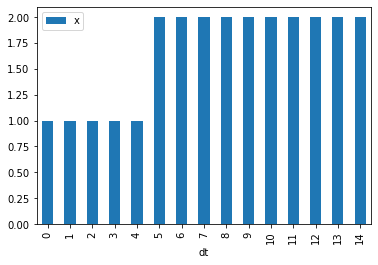

In [ ]:
df = pd.DataFrame({'dt':np.arange(0,15),
                  'x':L([1]*5) + L([2]*10),
                  })

df.plot(x='dt',y='x', kind='bar')

In [ ]:
r = melted_ts_2_lists(df,'x',to_split_col='dt',interval=1)
r[0].T

,0,1,2,3,4
dt,0,1,2,3,4
x,1,1,1,1,1


In [ ]:
r[1].T

,5,6,7,8,9,10,11,12,13,14
dt,5,6,7,8,9,10,11,12,13,14
x,2,2,2,2,2,2,2,2,2,2


In [ ]:
# hide
test_eq(type(r), type(L(0)))
test_eq(len(r), 2)

# test_eq_type(r[], df_end)

test_eq(r[0].shape, (5,2))
test_eq(r[1].shape, (10,2))

In [ ]:
# hide
df_start = pd.DataFrame({'dt':np.arange(0,15),
                         'x':L([1]*5) + L([2]*10),
                        })

df_end = pd.DataFrame({'dt':np.arange(20,25),                  
                       'x':L([1]*5) ,
                      })
df = pd.concat([df_start, df_end])

r = melted_ts_2_lists(df,'x',fn = make_interval, to_split_col='dt', interval=1)
test_eq(type(r), type(L(0)))
test_eq(len(r), 3)

test_eq_type(r[2], df_end)

test_eq(r[0].shape, (5,2))
test_eq(r[1].shape, (5,2))
test_eq(set(r[1]['x']), {1})
test_eq(r[2].shape, (10,2))
test_eq(set(r[2]['x']), {2})

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy